In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import torch
import random
import torch.nn as nn
import sklearn
import collections
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import json
from torch.optim import Adam
import pylab
from scipy.optimize import curve_fit
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Penn/Colab/Data/')
from functions import load_model, save_model, Dataset, mse_loss
from sklearn.metrics import roc_curve, auc
from IPython.display import Javascript
from scipy.stats import beta

Mounted at /content/gdrive


## Load Data

In [2]:
# Load Background data, which will be used for training
filename = 'BKG_dataset.h5'
with h5py.File('/content/gdrive/MyDrive/Penn/Colab/Data/BKG_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)

(640000, 57)


In [3]:
def calculate_pT_sum(x_in):
    """Calculate the sum of the pT of all objects for each event.
    Takes in [N, 57] and returns [N]."""

    x = x_in.reshape(-1, 19, 3, 1)
    pT = x[:, 1:, 0, 0]
    pT_sum = np.sum(pT, axis=1)
    return pT_sum

In [4]:
# Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return [torch.from_numpy(self.X[index]), torch.from_numpy(self.y[index])]

    def collate_fn(self, batch):
        X = [torch.tensor(sample[0]).float() for sample in batch]
        y = [torch.tensor(sample[1]).float() for sample in batch]
        return torch.stack(X, 0), torch.stack(y, 0)

    def create_dataloader(self, batch_size, shuffle=False, sampler=None):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, sampler=sampler)

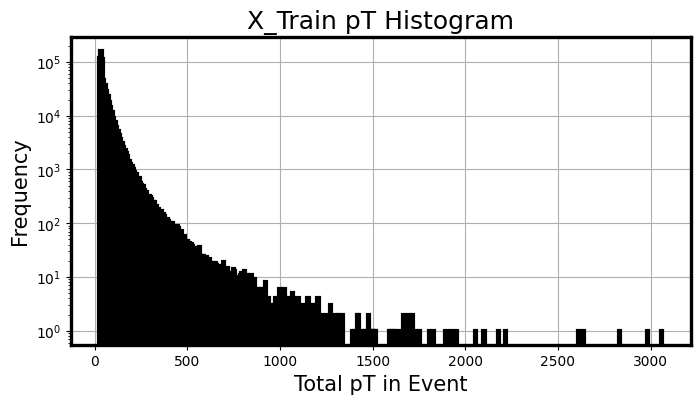

In [113]:
pT_sum = calculate_pT_sum(X_train)
freq, bin_edges = np.histogram(pT_sum, bins=400)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
indxs = np.digitize(pT_sum, bin_edges[:-1]) - 1


# Plot histogram before dropping events
plt.figure(figsize=(8, 4))
plt.rcParams['axes.linewidth'] = 2.4
plt.grid(zorder=0)
plt.bar(bin_centers, freq, width=bin_edges[1]-bin_edges[0], color='mediumvioletred', edgecolor='k', linewidth=3, zorder=2)
plt.yscale('log')
plt.xlabel('Total pT in Event', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title(f'X_Train pT Histogram', fontsize=18)
plt.show()

In [6]:
def calculate_class_weights(x_in, bins):
    """Takes in (usually) X_train, and calculates an array of the weights for each bin.
    Returns an array of size (bins,)."""
    pT_sum = calculate_pT_sum(x_in)

    freq, bin_edges = np.histogram(pT_sum, bins=bins)
    indxs = np.digitize(pT_sum, bin_edges[:-1]) - 1


    class_weights = 1 / freq
    class_weights[np.isinf(class_weights)] = 0.0

    return class_weights

In [7]:
def calculate_weights(x_in, bins, class_weights, hist=False):
    """Takes in any array and calculates the weight of each item according to the class_weights array.
    Returns an array of size (x_in,)"""
    pT_sum = calculate_pT_sum(x_in)

    freq, bin_edges = np.histogram(pT_sum, bins=bins)
    #bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    widths = bin_edges[1:]-bin_edges[:-1]
    widths[-1] = 10000


    # Plot
    if hist:
        plt.figure(figsize=(8, 4))
        plt.rcParams['axes.linewidth'] = 2.4
        plt.grid(zorder=0)
        plt.bar(bin_edges[:-1], freq, width=widths, color='mediumvioletred', edgecolor='k', linewidth=2.3, zorder=2, align='edge')
        plt.yscale('log')
        plt.xlabel('Total pT in Event', fontsize=15)
        plt.ylabel('Frequency', fontsize=15)
        plt.title(f'pT Histogram', fontsize=18)
        plt.xlim(-50, 3000)
        plt.show()


    indxs = np.digitize(pT_sum, bin_edges[:-1]) - 1

    weights = class_weights[indxs]

    return weights

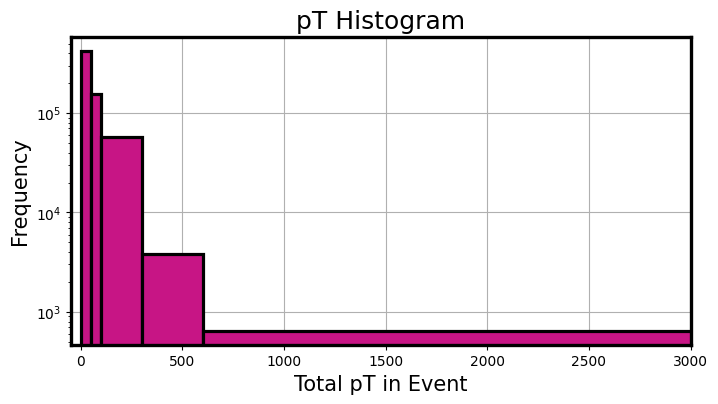

In [8]:
custom_bin_edges = [0, 50, 100, 300, 600, np.inf]
class_weights = calculate_class_weights(X_train, bins=custom_bin_edges)
weights_train = torch.DoubleTensor(calculate_weights(X_train, bins=custom_bin_edges, class_weights=class_weights, hist=True))
weights_val = torch.DoubleTensor(calculate_weights(X_val, bins=custom_bin_edges, class_weights=class_weights))

In [9]:
# Initialize samplers
train_sampler = torch.utils.data.WeightedRandomSampler(weights_train, len(weights_train))
val_sampler = torch.utils.data.WeightedRandomSampler(weights_val, len(weights_val))

In [10]:
# Initialize datasets
train_dataset = Dataset(X=X_train, y=X_train)
test_dataset = Dataset(X=X_test, y=X_test)
val_dataset = Dataset(X=X_val, y=X_val)

In [11]:
BATCH_SIZE = 1024

In [12]:
# Initialize dataloaders
train_loader = train_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False, sampler=train_sampler)
test_loader = test_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
val_loader = val_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False, sampler=val_sampler)
batch_X, batch_y = next(iter(train_loader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n")

Sample batch:
  X: [1024, 57]
  y: [1024, 57]



<ipython-input-4-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-4-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


## DNN and Trainer Classes

In [13]:
class DNN_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        """input_dim: dimension of the input data.
        latent_dim: dimension of the latent space. Should be smaller than all of the other layers.
        num_nodes: two element array containing the number of nodes in the two hidden layers."""
        super(DNN_AE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x_in):
        """Forward through the autoencoder with relu activation."""

        # Encoder
        z = F.relu(self.fc1(x_in))
        z = F.relu(self.fc2(z))

        # Decoder
        z = F.relu(self.fc3(z))
        z = self.fc4(z)
        return z

    def loss_function(self, x, y):
        # Define a mask which is False wherever an element of y is 0, True otherwise
        mask = (y != 0)

        # Apply the mask
        _x = mask * x
        _y = mask * y

        return F.mse_loss(_x, _y)


In [14]:
class Trainer(object):
    def __init__(self, model, num_batches_avg, loss_fn=None, optimizer=None, scheduler=None):
        """num_batches_avg: Number of batches to calculate the average loss over.
        example: if there are 625 batches, we might want to use 25, to calculate
        average loss over 25 batches."""

        #Set params
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_batches_avg = num_batches_avg

    def train_step(self, dataloader):
        """Train for one epoch.

        returns: average loss over most recent {num_batches_avg} batches, loss over most recent batch
        """

        self.model.train()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0

        # Iterate over batches in dataloader
        for i, batch in enumerate(dataloader):

            # Pass a single batch through the model and update the weights
            inputs, targets = batch
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)
            loss.backward()
            self.optimizer.step()

            # Update loss metrics
            running_loss += loss.item()
            current_loss = loss.item()

            # Calculate the average loss
            if i % self.num_batches_avg == self.num_batches_avg - 1:
                avg_loss = running_loss / self.num_batches_avg
                running_loss = 0.0

        return avg_loss, current_loss

    def eval_step(self, dataloader):
        """validation or test step over one epoch."""

        self.model.eval()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0
        y_trues, model_outputs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, y_true = batch
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, y_true)

                # Update loss metrics
                running_loss += loss.item()
                current_loss = loss.item()

                # Calculate the average loss
                if i % self.num_batches_avg == self.num_batches_avg - 1:
                    avg_loss = running_loss / self.num_batches_avg
                    running_loss = 0.0

                # Store outputs
                y_trues.extend(y_true)
                model_outputs.extend(outputs)
        return avg_loss, current_loss, np.vstack(y_trues), np.vstack(model_outputs)

    def predict_step(self, dataloader):
        """Prediction step."""
        self.model.eval()
        model_outputs = []
        model_inputs = []
        # Iterate over batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, targets = batch
                outputs = self.model(inputs)

                # Store outputs
                model_outputs.extend(outputs)
                model_inputs.extend(inputs)

        return np.vstack(model_outputs), np.vstack(model_inputs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        """Train the neural net."""

        best_val_loss = np.inf

        # Loop over epochs
        for epoch in range(num_epochs):

            # Steps
            avg_train_loss, last_train_loss = self.train_step(dataloader=train_dataloader)
            avg_val_loss, last_val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = self.model
                patience_counter = patience # reset patience
            else:
                patience_counter -= 1
            if not patience: # 0
                print("Stoping Early!")
                break

            # Logging
            print(f'Epoch: {epoch+1} | '
            f'average train loss over most recent {self.num_batches_avg} batches: {avg_train_loss},'
            f'average val loss over most recent {self.num_batches_avg} batches: {avg_val_loss},'
            #f'learning rate: {self.optimizer.param_groups[0]['lr']:.2E},'
            f'patience counter: {patience_counter}')

        return best_model

## Initialize Model and Train

In [15]:
# Define consts
LEARNING_RATE = 1e-3
PATIENCE = 6
NUM_EPOCHS = 20

In [16]:
# Initialize model
INPUT_DIM = X_train.shape[1]
HIDDEN_DIM = 32
LATENT_DIM = 8
dense_AE = DNN_AE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
print(dense_AE.named_parameters)

<bound method Module.named_parameters of DNN_AE(
  (fc1): Linear(in_features=57, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=57, bias=True)
)>


In [17]:
# Initialize the loss function, optimizer and lr scheduler, trainer

def loss_fn(x, y):
    return dense_AE.loss_function(x, y)

optimizer = Adam(params=dense_AE.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=3, verbose=True)
trainer = Trainer(model=dense_AE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    num_epochs=NUM_EPOCHS, patience=PATIENCE,
    train_dataloader=train_loader, val_dataloader=val_loader)

<ipython-input-64-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-64-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


Epoch: 1 | average train loss over most recent 25 batches: 117.56333038330078,average val loss over most recent 25 batches: 112.35957977294922,patience counter: 6
Epoch: 2 | average train loss over most recent 25 batches: 26.63943489074707,average val loss over most recent 25 batches: 25.951017913818358,patience counter: 6
Epoch: 3 | average train loss over most recent 25 batches: 21.73784309387207,average val loss over most recent 25 batches: 23.154071807861328,patience counter: 6
Epoch: 4 | average train loss over most recent 25 batches: 19.643678817749024,average val loss over most recent 25 batches: 21.838256072998046,patience counter: 6
Epoch: 5 | average train loss over most recent 25 batches: 18.468925170898437,average val loss over most recent 25 batches: 20.59172431945801,patience counter: 6
Epoch: 6 | average train loss over most recent 25 batches: 18.016381797790526,average val loss over most recent 25 batches: 20.962748260498046,patience counter: 5
Epoch: 7 | average train 

In [ ]:
# Save model
save_model(best_model, 'DNN_AE_sampler_1')

In [18]:
# Load model
dense_AE = DNN_AE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dense_AE = load_model(dense_AE, 'DNN_AE_sampler_1')
trainer = Trainer(model=dense_AE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

## Prediction

In [19]:
# signal labels
signal_labels = ['Ato4l', 'hChToTauNu', 'hToTauTau', 'leptoquark']

# path to signal files
drive_path = '/content/gdrive/MyDrive/Penn/Colab/Data/'
signals_file = [drive_path+label+'_dataset.h5' for label in signal_labels]
print(signals_file)

['/content/gdrive/MyDrive/Penn/Colab/Data/Ato4l_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hChToTauNu_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hToTauTau_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/leptoquark_dataset.h5']


In [20]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file[label])

    signal_dataset = Dataset(X=test_data, y=test_data)
    signal_loader = signal_dataset.create_dataloader(batch_size=len(test_data), shuffle=False)
    signal_data.append(signal_loader)

print(np.array(signal_data).shape)

(4,)


In [21]:
def AD_score(y, x):
    # Masked mse AD Score:
    mask = (y != 0)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [41]:
new_t_loader = train_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=True)
y_train, X_train = trainer.predict_step(new_t_loader)
score_train = AD_score(X_train, y_train)

<ipython-input-4-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-4-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


In [44]:
def calculate_threshold(score, rejection_rate):

    trueVal = np.zeros_like(score)

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, score, drop_intermediate=False)

    # Loop over thresholds
    for j, thresh in enumerate(threshold_loss):
        preds = (score >= thresh)
        n_bkg = len(preds) - np.sum(preds)
        n_sig = np.sum(preds)
        rej = np.inf if n_sig==0 else n_bkg / n_sig # number of background / number of anomaly

        # Breaking
        if rej < rejection_rate:
            print(f'Total Rejection = {rejec}')
            print(f'Threshold = {threshold}')
            break

        # update values
        threshold = thresh
        rejec = rej

    return threshold

In [78]:
REJECTION_RATE = pow(10, 4)

In [76]:
threshold = calculate_threshold(score=score_train, rejection_rate=REJECTION_RATE)

Total Rejection = 10157.730158730159
Threshold = 168.1229248046875


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [92]:
def predict_anomalies(X, score, bins, thresholds):
    # Pass the data through the model
    #prediction, inputs = trainer.predict_step(dataloader)
    #score = AD_score(inputs, prediction)

    pT_sum = calculate_pT_sum(X)
    freq, bin_edges = np.histogram(pT_sum, bins=bins)

    bin_indices = np.digitize(pT_sum, bin_edges[:-1]) - 1

    # Loops over bin indices
    pred_indices = []
    for i, bin_index in enumerate(np.unique(bin_indices)):
        # Collect the events and AD scores of those in the ith bin
        indices = np.where(bin_indices == i)[0] # indices of events in the ith bin
        if len(indices) == 0:
                continue
        #events = inputs[indices]
        #predVal_loss = score[indices]

        all_pred_indices = (np.where(score >= thresholds[i])[0]) # anomaly indices
        pred_indices.extend(np.intersect1d(all_pred_indices, indices))

    return np.vstack(pred_indices), X

In [107]:
def update_thresholds(X, score, bins, rejection_rate, total_threshold):
    """Input the training datalader, trainer, number of bins, desired rejection rate,
    and also the threshold as calculated on the entire dataset.
    Outputs the thresholds corresponding to each bin."""

    pT_sum = calculate_pT_sum(X)
    freq, bin_edges = np.histogram(pT_sum, bins=bins)

    bin_indices = np.digitize(pT_sum, bin_edges[:-1]) - 1


    total_rejection_rate = 0
    while total_rejection_rate < rejection_rate:

        total_threshold += 20

        thresholds = []
        total_bkg = 0
        total_sig = 0
        # Loops over bin indices
        for i, bin_index in enumerate(np.unique(bin_indices)):
            # Collect the events and AD scores of those in the ith bin
            indices = np.where(bin_indices == i)[0]
            events = X[indices]
            predVal_loss = score[indices]

            # Calculate fpr, tpr, thresholds
            trueVal = np.zeros_like(predVal_loss)
            if len(trueVal) == 0:
                thresholds.append(total_threshold)
                continue

            fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss, drop_intermediate=False)

            # Loop over thresholds
            for j, thresh in enumerate(threshold_loss):
                preds = (predVal_loss >= thresh)
                n_bkg = len(preds) - np.sum(preds)
                n_sig = np.sum(preds)
                rej = np.inf if n_sig==0 else n_bkg / n_sig # number of background / number of anomaly

                # update values
                threshold = thresh
                rejec = rej

                # Breaking
                if rej < rejection_rate:
                    break

            if threshold < total_threshold:
                thresholds.append(threshold)
            else:
                thresholds.append(total_threshold)

        pred_indices, inputs = predict_anomalies(X, score, bins=bins, thresholds=thresholds)
        total_rejection_rate = (len(inputs) - len(pred_indices)) / len(pred_indices)
        print(f'\ntotal rejection rate = {total_rejection_rate}')
        print(f'thresholds = {thresholds}\n')

    print(total_rejection_rate)
    return thresholds

In [120]:
BINS = np.append(np.arange(0, 140, 20), [10000])
#BINS=4

In [121]:
thresholds = update_thresholds(X_train, score_train, bins=BINS, rejection_rate=REJECTION_RATE, total_threshold=threshold)
print(thresholds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(



total rejection rate = 10157.730158730159
thresholds = [188.1229248046875, 5.9016356, 11.7792635, 15.467501, 21.803879, 34.413914]

10157.730158730159
[188.1229248046875, 5.9016356, 11.7792635, 15.467501, 21.803879, 34.413914]


In [122]:
def predict_anomalies(dataloader, bins, thresholds):
    # Pass the data through the model
    prediction, inputs = trainer.predict_step(dataloader)
    score = AD_score(inputs, prediction)

    pT_sum = calculate_pT_sum(inputs)
    freq, bin_edges = np.histogram(pT_sum, bins=bins)

    bin_indices = np.digitize(pT_sum, bin_edges[:-1]) - 1

    # Loops over bin indices
    pred_indices = []
    for i, bin_index in enumerate(np.unique(bin_indices)):
        # Collect the events and AD scores of those in the ith bin
        indices = np.where(bin_indices == i)[0] # indices of events in the ith bin
        #events = inputs[indices]
        #predVal_loss = score[indices]

        all_pred_indices = (np.where(score >= thresholds[i])[0]) # anomaly indices
        pred_indices.extend(np.intersect1d(all_pred_indices, indices))

    return np.vstack(pred_indices), inputs

In [59]:
pred_indices, inputs = predict_anomalies(new_t_loader, bins=10, thresholds=thresholds)
print(f'Total Rejection Rate = {(len(inputs) - len(pred_indices)) / len(pred_indices)}')

<ipython-input-4-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-4-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


Total Rejection Rate = 5119.0


<IPython.core.display.Javascript object>

<ipython-input-4-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-4-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


Ato4l: tpr = 0.0015722989512051313


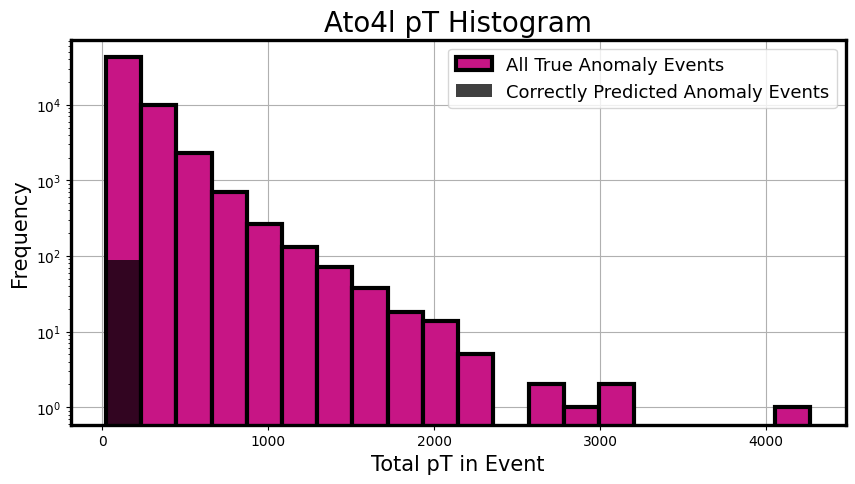

<ipython-input-123-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-123-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-123-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-123-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-123-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal wi

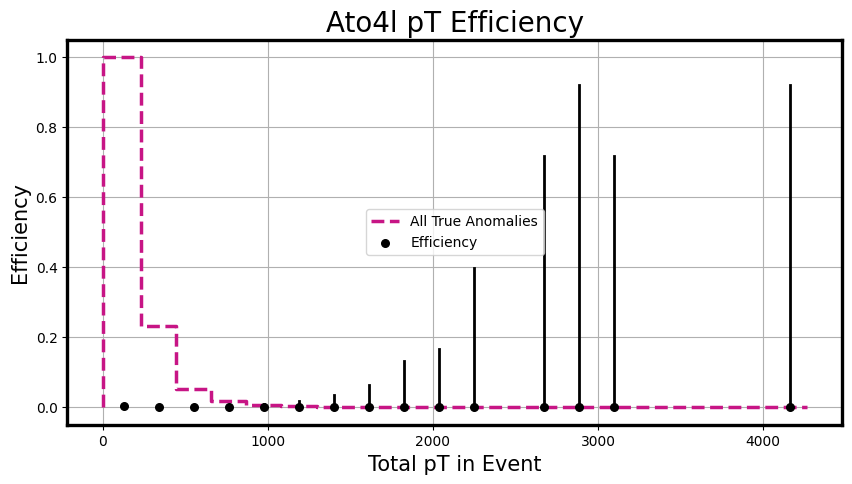

_________________________________________________________________________________________________


<ipython-input-4-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-4-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


hChToTauNu: tpr = 0.0005037670728370899


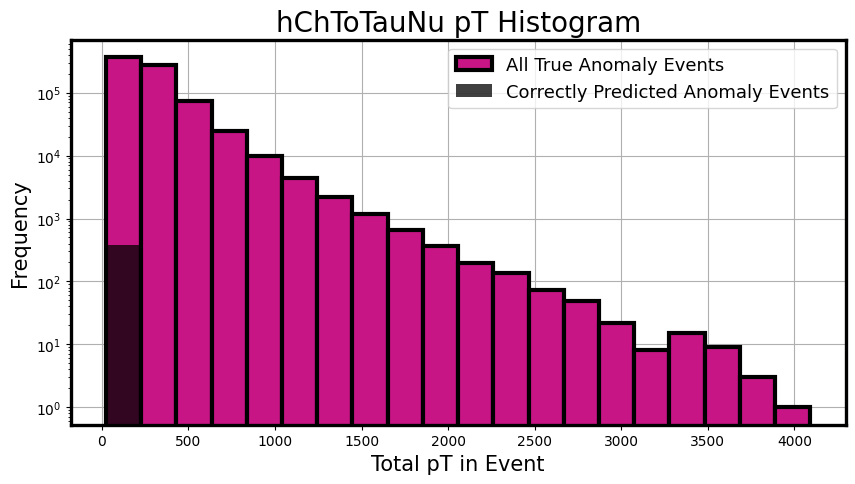

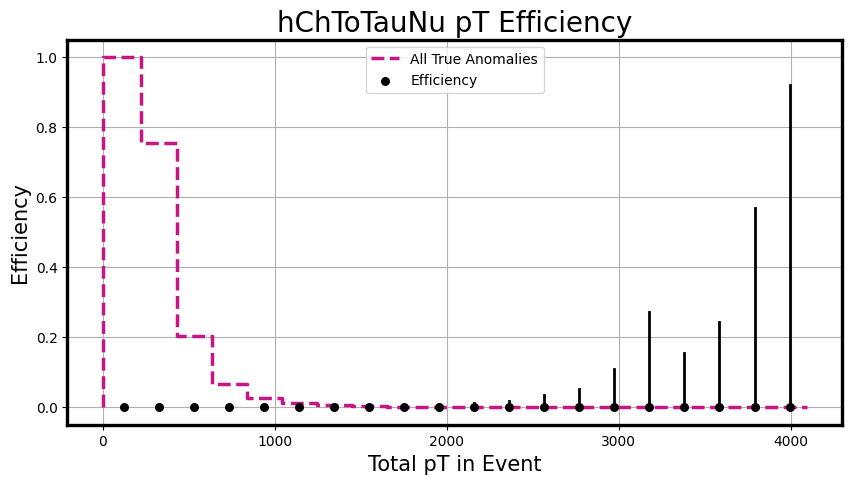

_________________________________________________________________________________________________


<ipython-input-4-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-4-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


KeyboardInterrupt: ignored

In [123]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 20000})''')) # No scroll bar

labels = np.concatenate([['Background'], np.array(signal_labels)])
for j, label in enumerate(labels):
    if j ==0: continue # bkg
    loader = test_loader if j == 0 else signal_data[j-1]
    sig_indices, inputs = predict_anomalies(loader, bins=BINS, thresholds=thresholds)

    print(f'{label}: tpr = {len(sig_indices) / len(inputs)}')

    pT_sum = calculate_pT_sum(inputs)

    pT_hist_A, edges_A = np.histogram(pT_sum, bins=20) # all true events
    pT_hist_B, edges_B = np.histogram(pT_sum[sig_indices], bins=20, range=(pT_sum.min(), pT_sum.max())) # only true events that were correctly predicted as anomalous
    bin_centers = edges_A[0:-1] + ((edges_A[1] - edges_A[0])/2)

    # Plot Histograms
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Histogram', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.bar(bin_centers, pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=3, zorder=2, label='All True Anomaly Events')
    plt.bar(bin_centers, pT_hist_B, width=(edges_A[1] - edges_A[0]), color='k', zorder=3, label='Correctly Predicted Anomaly Events', alpha=0.75)
    plt.yscale('log')
    plt.legend(fontsize=13)
    plt.show()
    print('')

    # Plot Efficiency
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Efficiency', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Efficiency', fontsize=15)
    #plt.bar(bin_centers, pT_hist_B/pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=2.5, zorder=2)
    step_x = np.append(np.insert(bin_centers, 0, [0, 0]), bin_centers[-1] + (edges_A[1] - edges_A[0])/2)
    step_y = np.append(np.insert(pT_hist_A/np.amax(pT_hist_A), 0, [0, (pT_hist_A/np.amax(pT_hist_A))[0]]), 0)
    plt.step(step_x, step_y, where='mid', color='mediumvioletred', linestyle='dashed', linewidth=2.5, zorder=2, label='All True Anomalies')

    # Error Bars
    y_err = np.empty((2, len(pT_hist_A)))
    alpha = 0.16
    for i in range(len(pT_hist_A)):
        k = pT_hist_B[i]
        n = pT_hist_A[i]
        p_u, p_o = beta.ppf([alpha/2, 1 - alpha/2], [k, k + 1], [n - k + 1, n - k])
        y_err[0, i] = p_u
        y_err[1, i] = p_o
        if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
            plt.plot([bin_centers[i], bin_centers[i]], np.nan_to_num([p_u, p_o], nan=0), color='k', linewidth=2)
        else:
            plt.plot([bin_centers[i], bin_centers[i]], np.nan_to_num([p_u, p_o], nan=1), color='k', linewidth=2)

    plt.scatter(bin_centers, pT_hist_B/pT_hist_A, color='k', s=30, zorder=7, label='Efficiency')

    plt.legend()
    plt.show()
    print('_________________________________________________________________________________________________')



Okay so I tried variable thresholds, setting the threshold in each bin roughly equal to 10^4. This didn't work great (see below). So I tried making the threshold of the first few bins lower, and making the thresholds of the other bins equal, and higher. This looked like the regular sampler plots, except the 2nd, 3rd, 4th bins were slightly up from 0. Then I tried a more complex threshold calculation method, which is currently coded up there, and either I was not able to reach a rejection of 10^4, or it did not help at all.

_________________

In [57]:
def calculate_thresholds(dataloader, trainer, bins, rejection_rate):
    """Input the training datalader, trainer, number of bins, and desired rejection rate.
    Outputs the thresholds corresponding to each bin."""

    # Pass the data through the model
    prediction, inputs = trainer.predict_step(dataloader)
    #score = AD_score(prediction, inputs)
    score = AD_score(inputs, prediction)

    pT_sum = calculate_pT_sum(inputs)
    freq, bin_edges = np.histogram(pT_sum, bins=bins)

    bin_indices = np.digitize(pT_sum, bin_edges[:-1]) - 1

    thresholds = []
    total_bkg = 0
    total_sig = 0
    # Loops over bin indices
    for i, bin_index in enumerate(np.unique(bin_indices)):
        # Collect the events and AD scores of those in the ith bin
        indices = np.where(bin_indices == i)[0]
        events = inputs[indices]
        predVal_loss = score[indices]

        # Calculate fpr, tpr, thresholds
        trueVal = np.zeros_like(predVal_loss)

        fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss, drop_intermediate=False)

        # Loop over thresholds
        for j, thresh in enumerate(threshold_loss):
            preds = (predVal_loss >= thresh)
            n_bkg = len(preds) - np.sum(preds)
            n_sig = np.sum(preds)
            rej = n_bkg / n_sig # number of background / number of anomaly

            # update values
            threshold = thresh
            rejec = rej

            # Breaking
            if rej < rejection_rate:

                _thresh = threshold_loss[j-1]
                _preds = (predVal_loss >= _thresh)
                _n_bkg = len(_preds) - np.sum(_preds)
                _n_sig = np.sum(_preds)
                _rej = _n_bkg / _n_sig

                if _rej < pow(10, 10):
                    rejec = _n_bkg / _n_sig
                    threshold = _thresh
                    n_bkg = _n_bkg
                    n_sig = _n_sig
                break

        thresholds.append(threshold)
        print(f'bkg: {n_bkg}, sig: {n_sig}')
        total_bkg += n_bkg
        total_sig += n_sig
        print(f'rejecion rate of {i}th bin: {rejec:.2f}')
        print('')

    total_rejection = total_bkg / total_sig

    print(f'total rejection of entire dataset = {total_rejection:.2f}')
    return thresholds

In [65]:
BINS = np.append(np.arange(0, 550, 50), [750, 10000])
print(BINS)
REJECTION_RATE = pow(10, 4)

[    0    50   100   150   200   250   300   350   400   450   500   750
 10000]


In [85]:
new_t_loader = train_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=True)
thresholds = calculate_thresholds(new_t_loader, trainer, bins=BINS, rejection_rate=REJECTION_RATE)

<ipython-input-4-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-4-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


bkg: 423618, sig: 42
rejecion rate of 0th bin: 10086.14

bkg: 154013, sig: 15
rejecion rate of 1th bin: 10267.53

bkg: 37095, sig: 3
rejecion rate of 2th bin: 12365.00

bkg: 12628, sig: 1
rejecion rate of 3th bin: 12628.00

bkg: 5465, sig: 1
rejecion rate of 4th bin: 5465.00

bkg: 2673, sig: 1
rejecion rate of 5th bin: 2673.00

bkg: 1490, sig: 1
rejecion rate of 6th bin: 1490.00

bkg: 909, sig: 1
rejecion rate of 7th bin: 909.00

bkg: 599, sig: 1
rejecion rate of 8th bin: 599.00

bkg: 373, sig: 1
rejecion rate of 9th bin: 373.00

bkg: 729, sig: 1
rejecion rate of 10th bin: 729.00

bkg: 339, sig: 1
rejecion rate of 11th bin: 339.00

total rejection of entire dataset = 9274.36


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
<ipython-input-57-05afd282831e>:35: RuntimeWarning: divide by zero encountered in long_scalars
  rej = n_bkg / n_sig # number of background / number of anomaly
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
<ipython-input-57-05afd282831e>:35: RuntimeWarning: divide by zero encountered in long_scalars
  rej = n_bkg / n_sig # number of background / number of anomaly
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
<ipython-input-57-05afd282831e>:35: RuntimeWarning: divide by zero encountered in long_scalars
  rej = n_bkg / n_sig

In [86]:
print(thresholds)

[8.067228, 19.073854, 51.94036, 174.82887, 107.83715, 166.68794, 181.04477, 184.87839, 232.32997, 333.55032, 414.0687, 1150.435]


In [112]:
def predict_anomalies(dataloader, bins, thresholds):
    # Pass the data through the model
    prediction, inputs = trainer.predict_step(dataloader)
    score = AD_score(inputs, prediction)

    pT_sum = calculate_pT_sum(inputs)
    freq, bin_edges = np.histogram(pT_sum, bins=bins)

    bin_indices = np.digitize(pT_sum, bin_edges[:-1]) - 1

    # Loops over bin indices
    pred_indices = []
    for i, bin_index in enumerate(np.unique(bin_indices)):
        # Collect the events and AD scores of those in the ith bin
        indices = np.where(bin_indices == i)[0] # indices of events in the ith bin
        #events = inputs[indices]
        #predVal_loss = score[indices]

        all_pred_indices = (np.where(score >= thresholds[i])[0]) # anomaly indices
        pred_indices.extend(np.intersect1d(all_pred_indices, indices))

    return np.vstack(pred_indices), inputs

<IPython.core.display.Javascript object>

<ipython-input-4-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-4-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


Ato4l: tpr = 0.004091550679840626


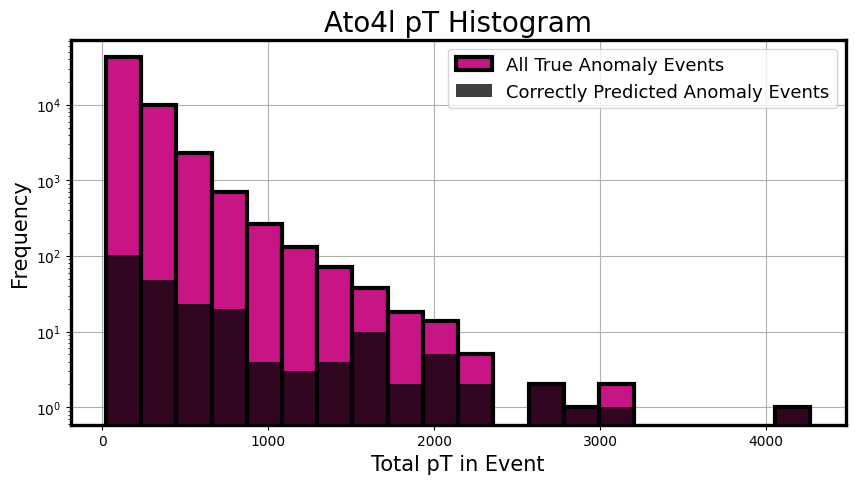

<ipython-input-125-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-125-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-125-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-125-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-125-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal wi

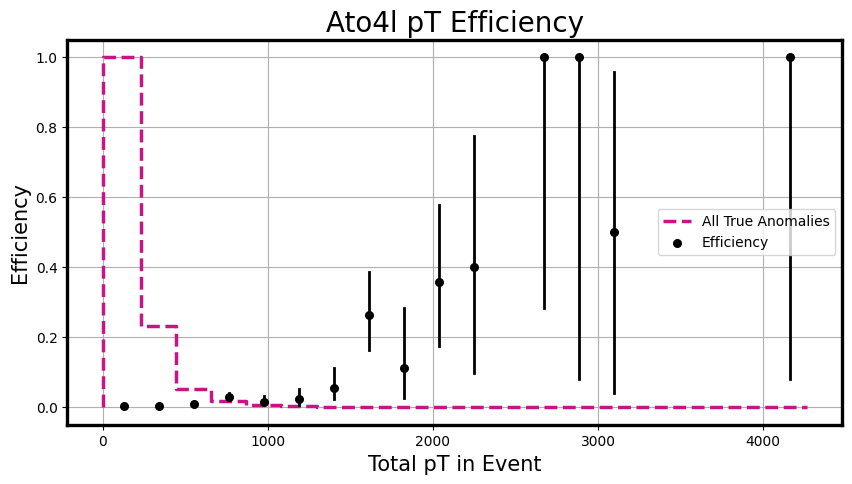

_________________________________________________________________________________________________


<ipython-input-4-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-4-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


hChToTauNu: tpr = 0.0021781678136245973


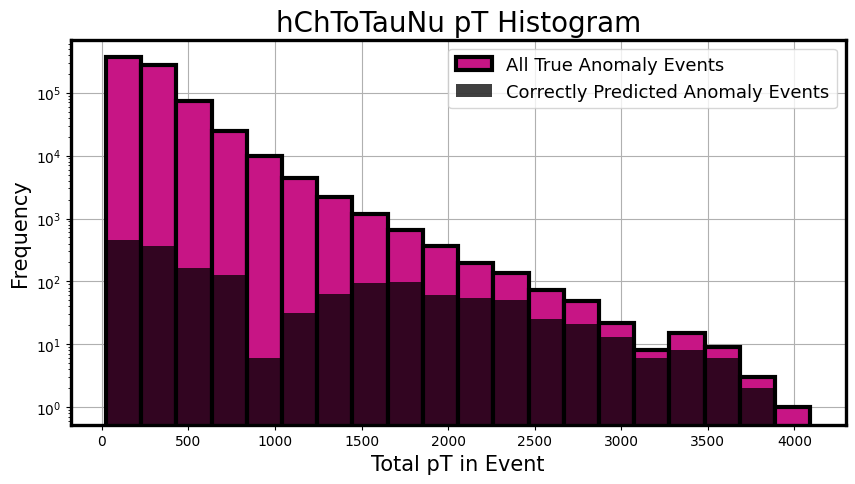

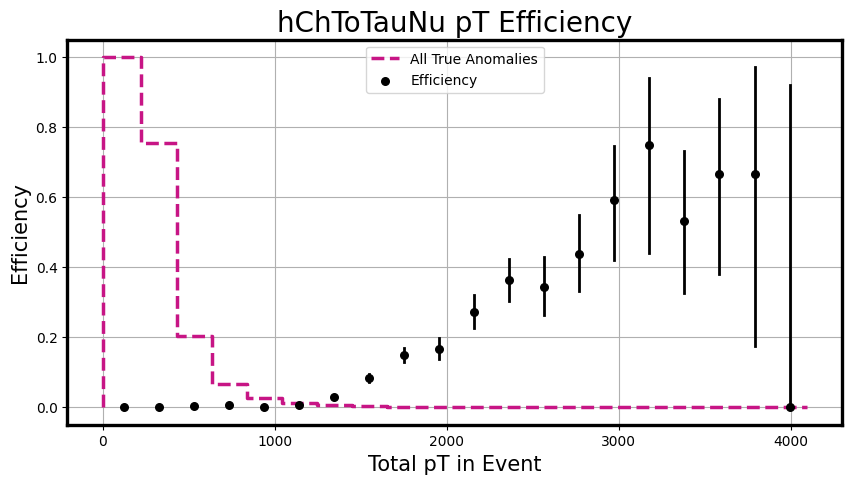

_________________________________________________________________________________________________


<ipython-input-4-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-4-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


hToTauTau: tpr = 0.0007478847302768909


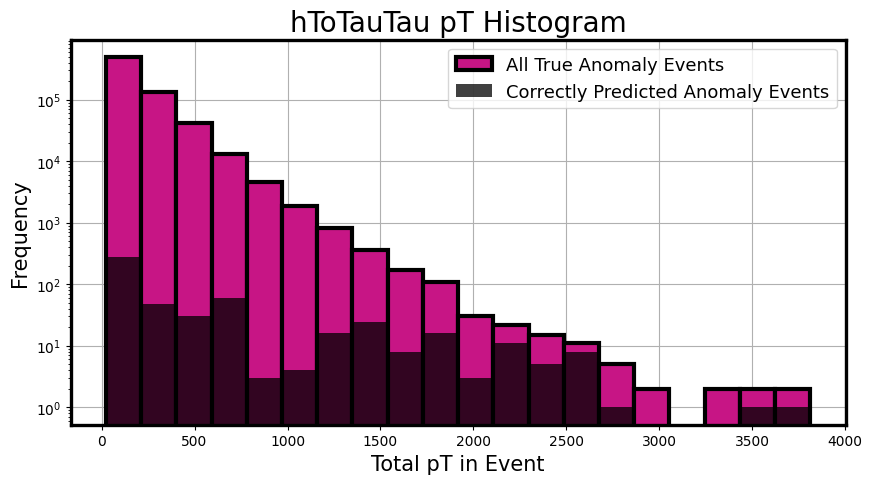

<ipython-input-125-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-125-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-125-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-125-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
<ipython-input-125-d7e7a4576ad4>:52: RuntimeWarning: invalid value encountered in true_divide
  if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal wi

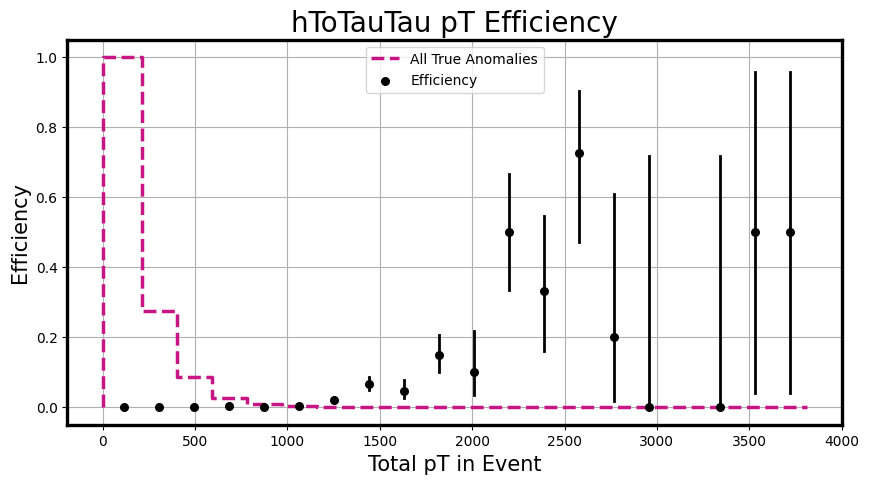

_________________________________________________________________________________________________


<ipython-input-4-88abfe6357ad>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
<ipython-input-4-88abfe6357ad>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


leptoquark: tpr = 0.00026134655140011277


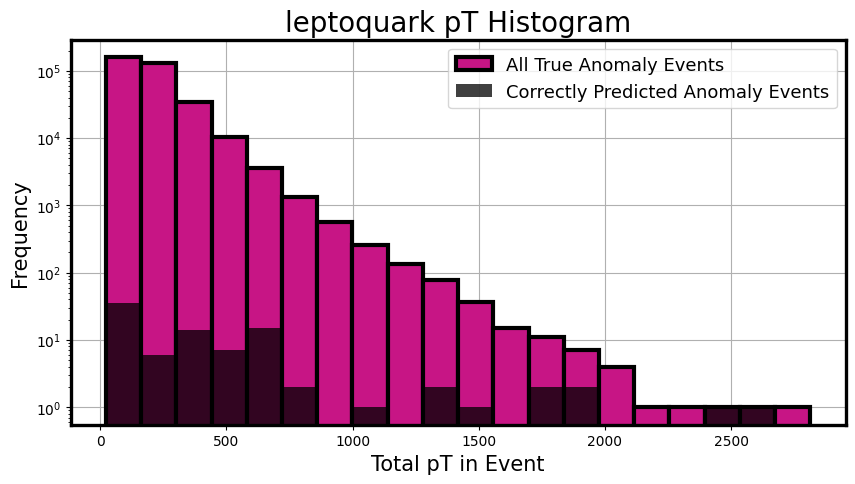

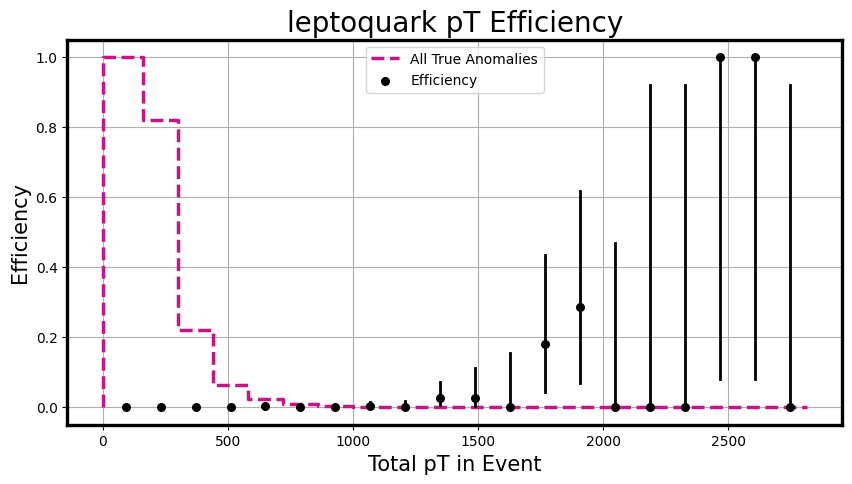

_________________________________________________________________________________________________


In [125]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 20000})''')) # No scroll bar

labels = np.concatenate([['Background'], np.array(signal_labels)])
for j, label in enumerate(labels):
    if j ==0: continue # bkg
    loader = test_loader if j == 0 else signal_data[j-1]
    sig_indices, inputs = predict_anomalies(loader, bins=BINS, thresholds=thresholds)

    print(f'{label}: tpr = {len(sig_indices) / len(inputs)}')

    pT_sum = calculate_pT_sum(inputs)

    pT_hist_A, edges_A = np.histogram(pT_sum, bins=20) # all true events
    pT_hist_B, edges_B = np.histogram(pT_sum[sig_indices], bins=20, range=(pT_sum.min(), pT_sum.max())) # only true events that were correctly predicted as anomalous
    bin_centers = edges_A[0:-1] + ((edges_A[1] - edges_A[0])/2)

    # Plot Histograms
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Histogram', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.bar(bin_centers, pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=3, zorder=2, label='All True Anomaly Events')
    plt.bar(bin_centers, pT_hist_B, width=(edges_A[1] - edges_A[0]), color='k', zorder=3, label='Correctly Predicted Anomaly Events', alpha=0.75)
    plt.yscale('log')
    plt.legend(fontsize=13)
    plt.show()
    print('')

    # Plot Efficiency
    plt.figure(figsize=(10, 5))
    plt.rcParams['axes.linewidth'] = 2.4
    plt.grid(zorder=0)
    plt.title(f'{label} pT Efficiency', fontsize=20)
    plt.xlabel('Total pT in Event', fontsize=15)
    plt.ylabel('Efficiency', fontsize=15)
    #plt.bar(bin_centers, pT_hist_B/pT_hist_A, width=(edges_A[1] - edges_A[0]), color='mediumvioletred', edgecolor='k', linewidth=2.5, zorder=2)
    step_x = np.append(np.insert(bin_centers, 0, [0, 0]), bin_centers[-1] + (edges_A[1] - edges_A[0])/2)
    step_y = np.append(np.insert(pT_hist_A/np.amax(pT_hist_A), 0, [0, (pT_hist_A/np.amax(pT_hist_A))[0]]), 0)
    plt.step(step_x, step_y, where='mid', color='mediumvioletred', linestyle='dashed', linewidth=2.5, zorder=2, label='All True Anomalies')

    # Error Bars
    y_err = np.empty((2, len(pT_hist_A)))
    alpha = 0.16
    for i in range(len(pT_hist_A)):
        k = pT_hist_B[i]
        n = pT_hist_A[i]
        p_u, p_o = beta.ppf([alpha/2, 1 - alpha/2], [k, k + 1], [n - k + 1, n - k])
        y_err[0, i] = p_u
        y_err[1, i] = p_o
        if (pT_hist_B/pT_hist_A)[i] < 0.1: # If statement to deal with nan values when the outputs are too close to 1 or 0
            plt.plot([bin_centers[i], bin_centers[i]], np.nan_to_num([p_u, p_o], nan=0), color='k', linewidth=2)
        else:
            plt.plot([bin_centers[i], bin_centers[i]], np.nan_to_num([p_u, p_o], nan=1), color='k', linewidth=2)

    plt.scatter(bin_centers, pT_hist_B/pT_hist_A, color='k', s=30, zorder=7, label='Efficiency')

    plt.legend()
    plt.show()
    print('_________________________________________________________________________________________________')

